<a href="https://colab.research.google.com/github/ofAiden/Duplicate-Charged-Particle-Tracks-with-ML-professor-Tuna/blob/main/embed_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
! pip install uproot numpy matplotlib scikit-learn torch awkward

In [21]:
!pip install -q gdown

import gdown
import os

FILE_ID = "13Xy0ULQvhWoSwqHvsIr7hie1rYian6sg"
file_path = "pls_t5_embed.root"

if not os.path.exists(file_path):
  print(f"Downloading {file_path} ~ 3.5 GB rom Google Drive")
  gdown.download(f"https://drive.google.com/uc?id={FILE_ID}",
                  file_path,
                  quiet=False)
  print("Download completed!")
else:
  print("Fail")

Fail


In [22]:

import os
import uproot
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import random
import awkward as ak # Using awkward array for easier handling of jagged data
import time # For timing steps

# Set seeds for reproducibility
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
os.environ['PYTHONHASHSEED'] = str(seed_value)

def load_root_file(file_path, branches=None, print_branches=False):
    all_branches = {}
    print("Entering `with` statement!")
    with uproot.open(file_path) as file:
        print("Entered! Grabbing tree.")
        tree = file["tree"]
        print("Grabbed the tree.")
        # Load all ROOT branches into array if not specified
        if branches is None:
            branches = tree.keys()
        # Option to print the branch names
        if print_branches:
            print("Branches:", tree.keys())
        # Each branch is added to the dictionary
        for i_branch, branch in enumerate(branches):
            try:
                all_branches[branch] = (tree[branch].array(library="np"))
            except uproot.KeyInFileError as e:
                print(f"KeyInFileError: {e}")
            print(branch, i_branch, len(branches))
        # Number of events in file
        all_branches['event'] = tree.num_entries
    return all_branches

branches_list = [
    't5_innerRadius',
    't5_bridgeRadius',
    't5_outerRadius',
    't5_pt',
    't5_eta',
    't5_phi',
    't5_isFake',
    't5_t3_idx0',
    't5_t3_idx1',

    't5_t3_fakeScore1',
    't5_t3_promptScore1',
    't5_t3_displacedScore1',
    't5_t3_fakeScore2',
    't5_t3_promptScore2',
    't5_t3_displacedScore2',

    't5_pMatched',
    't5_sim_vxy',
    't5_sim_vz',
    't5_matched_simIdx'
]

branches_list += [
    'pLS_eta',
    'pLS_etaErr',
    'pLS_phi',
    'pLS_matched_simIdx',
    'pLS_circleCenterX',
    'pLS_circleCenterY',
    'pLS_circleRadius',
    'pLS_ptIn',
    'pLS_ptErr',
    'pLS_px',
    'pLS_py',
    'pLS_pz',
    'pLS_isQuad',
    'pLS_isFake'
]

# Hit-dependent branches
suffixes = ['r', 'z', 'eta', 'phi', 'layer']
branches_list += [f't5_t3_{i}_{suffix}' for i in [0, 2, 4] for suffix in suffixes]

file_path = "/content/pls_t5_embed.root"
branches = load_root_file(file_path, branches_list, print_branches=True)

Entering `with` statement!
Entered! Grabbing tree.
Grabbed the tree.
Branches: ['sim_pt', 'sim_eta', 'sim_phi', 'sim_pca_dxy', 'sim_pca_dz', 'sim_q', 'sim_event', 'sim_pdgId', 'sim_vx', 'sim_vy', 'sim_vz', 'sim_trkNtupIdx', 'sim_TC_matched', 'sim_TC_matched_mask', 'tc_pt', 'tc_eta', 'tc_phi', 'tc_type', 'tc_isFake', 'tc_isDuplicate', 'tc_matched_simIdx', 'sim_dummy', 'tc_dummy', 'pT5_matched_simIdx', 'pT5_hitIdxs', 'sim_pT5_matched', 'pT5_pt', 'pT5_eta', 'pT5_phi', 'pT5_isFake', 't5_sim_vxy', 't5_sim_vz', 'pT5_isDuplicate', 'pT5_score', 'pT5_layer_binary', 'pT5_moduleType_binary', 'pT5_matched_pt', 'pT5_rzChiSquared', 'pT5_rPhiChiSquared', 'pT5_rPhiChiSquaredInwards', 'sim_pT3_matched', 'pT3_pt', 'pT3_isFake', 'pT3_isDuplicate', 'pT3_eta', 'pT3_phi', 'pT3_score', 'pT3_foundDuplicate', 'pT3_matched_simIdx', 'pT3_hitIdxs', 'pT3_pixelRadius', 'pT3_pixelRadiusError', 'pT3_matched_pt', 'pT3_tripletRadius', 'pT3_rPhiChiSquared', 'pT3_rPhiChiSquaredInwards', 'pT3_rzChiSquared', 'pT3_layer_bin

In [23]:
z_max = np.max([np.max(event) for event in branches[f't5_t3_4_z']])
r_max = np.max([np.max(event) for event in branches[f't5_t3_4_r']])
eta_max = 2.5
phi_max = np.pi
n_events = np.shape(branches['t5_pt'])[0]

print(f'Z max: {z_max}, R max: {r_max}, Eta max: {eta_max}')

def delta_phi(phi1, phi2):
    delta = phi1 - phi2
    # Adjust delta to be within the range [-pi, pi]
    if delta > np.pi:
        delta -= 2 * np.pi
    elif delta < -np.pi:
        delta += 2 * np.pi
    return delta

Z max: 267.2349853515625, R max: 110.10993957519531, Eta max: 2.5


In [24]:
pMATCHED_THRESHOLD = 0.        # keep if t5_pMatched ≥ this
print(f"\nBuilding T5 features  (pMatched ≥ {pMATCHED_THRESHOLD}) …")

features_per_event    = []
eta_per_event         = []
displaced_per_event = []
sim_indices_per_event = []

kept_tot, init_tot = 0, 0
for ev in range(n_events):

    n_t5 = len(branches['t5_t3_idx0'][ev])
    init_tot += n_t5
    if n_t5 == 0:
        continue

    feat_evt = []
    eta_evt  = []
    sim_evt  = []
    disp_evt = []

    for i in range(n_t5):
        if branches['t5_pMatched'][ev][i] < pMATCHED_THRESHOLD:
            continue

        idx0 = branches['t5_t3_idx0'][ev][i]
        idx1 = branches['t5_t3_idx1'][ev][i]

        # hit-level quantities -------------------------------------------------
        eta1 = (branches['t5_t3_0_eta'][ev][idx0])
        eta2 = abs(branches['t5_t3_2_eta'][ev][idx0])
        eta3 = abs(branches['t5_t3_4_eta'][ev][idx0])
        eta4 = abs(branches['t5_t3_2_eta'][ev][idx1])
        eta5 = abs(branches['t5_t3_4_eta'][ev][idx1])

        phi1 = branches['t5_t3_0_phi'][ev][idx0]
        phi2 = branches['t5_t3_2_phi'][ev][idx0]
        phi3 = branches['t5_t3_4_phi'][ev][idx0]
        phi4 = branches['t5_t3_2_phi'][ev][idx1]
        phi5 = branches['t5_t3_4_phi'][ev][idx1]

        z1 = abs(branches['t5_t3_0_z'][ev][idx0])
        z2 = abs(branches['t5_t3_2_z'][ev][idx0])
        z3 = abs(branches['t5_t3_4_z'][ev][idx0])
        z4 = abs(branches['t5_t3_2_z'][ev][idx1])
        z5 = abs(branches['t5_t3_4_z'][ev][idx1])

        r1 = branches['t5_t3_0_r'][ev][idx0]
        r2 = branches['t5_t3_2_r'][ev][idx0]
        r3 = branches['t5_t3_4_r'][ev][idx0]
        r4 = branches['t5_t3_2_r'][ev][idx1]
        r5 = branches['t5_t3_4_r'][ev][idx1]

        inR  = branches['t5_innerRadius' ][ev][i]
        brR  = branches['t5_bridgeRadius'][ev][i]
        outR = branches['t5_outerRadius' ][ev][i]

        s1_fake   = branches['t5_t3_fakeScore1'     ][ev][i]
        s1_prompt = branches['t5_t3_promptScore1'   ][ev][i]
        s1_disp   = branches['t5_t3_displacedScore1'][ev][i]
        d_fake    = branches['t5_t3_fakeScore2'     ][ev][i] - s1_fake
        d_prompt  = branches['t5_t3_promptScore2'   ][ev][i] - s1_prompt
        d_disp    = branches['t5_t3_displacedScore2'][ev][i] - s1_disp

        f = [
            eta1 / eta_max,
            np.cos(phi1),
            np.sin(phi1),
            z1 / z_max,
            r1 / r_max,

            eta2 - abs(eta1),
            delta_phi(phi2, phi1),
            (z2 - z1) / z_max,
            (r2 - r1) / r_max,

            eta3 - eta2,
            delta_phi(phi3, phi2),
            (z3 - z2) / z_max,
            (r3 - r2) / r_max,

            eta4 - eta3,
            delta_phi(phi4, phi3),
            (z4 - z3) / z_max,
            (r4 - r3) / r_max,

            eta5 - eta4,
            delta_phi(phi5, phi4),
            (z5 - z4) / z_max,
            (r5 - r4) / r_max,

            1.0 / inR,
            1.0 / brR,
            1.0 / outR,

            s1_fake, s1_prompt, s1_disp,
            d_fake,  d_prompt,  d_disp
        ]
        feat_evt.append(f)
        eta_evt.append(eta1)
        disp_evt.append(branches['t5_sim_vxy'][ev][i])

        # first (or only) matched sim-index, -1 if none -----------------------
        simIdx_list = branches['t5_matched_simIdx'][ev][i]
        sim_evt.append(simIdx_list[0] if len(simIdx_list) else -1)

    # push to global containers ----------------------------------------------
    if feat_evt:                                # skip events with no survivors
        features_per_event.append(np.asarray(feat_evt, dtype=np.float32))
        eta_per_event.append(np.asarray(eta_evt,  dtype=np.float32))
        displaced_per_event.append(np.asarray(disp_evt, dtype=np.float32))
        sim_indices_per_event.append(np.asarray(sim_evt, dtype=np.int64))
        kept_tot += len(feat_evt)
features_per_event = features_per_event[:20] #max events to consider= 20
print(f"\nKept {kept_tot} / {init_tot} T5s "
      f"({kept_tot/init_tot*100:.2f} %) that passed the pMatched cut.")
print(f"Total events with ≥1 kept T5: {len(features_per_event)}")


Building T5 features  (pMatched ≥ 0.0) …

Kept 3630781 / 3630781 T5s (100.00 %) that passed the pMatched cut.
Total events with ≥1 kept T5: 20


In [25]:
KEEP_FRAC_PLS = 0.40
print(f"\nBuilding pLS features …")

pLS_features_per_event    = []
pLS_eta_per_event         = []
pLS_sim_indices_per_event = []

kept_tot_pls, init_tot_pls = 0, 0
for ev in range(n_events):
    n_pls = len(branches['pLS_eta'][ev])
    init_tot_pls += n_pls
    if n_pls == 0:
        continue

    feat_evt, eta_evt, sim_evt = [], [], []

    for i in range(n_pls):
        if branches['pLS_isFake'][ev][i]:
            continue
        if np.random.random() > KEEP_FRAC_PLS:
            continue

        # ――― hit‑level quantities -------------------------------------------
        eta = branches['pLS_eta'][ev][i]
        etaErr = branches['pLS_etaErr'][ev][i]
        phi = branches['pLS_phi'][ev][i]
        circleCenterX = np.abs(branches['pLS_circleCenterX'][ev][i])
        circleCenterY = np.abs(branches['pLS_circleCenterY'][ev][i])
        circleRadius = branches['pLS_circleRadius'][ev][i]
        ptIn = branches['pLS_ptIn'][ev][i]
        ptErr = branches['pLS_ptErr'][ev][i]
        isQuad = branches['pLS_isQuad'][ev][i]

        # ――― build feature vector -------------------------------------------
        f = [
            eta/4.0,
            etaErr/.00139,
            np.cos(phi),
            np.sin(phi),
            1.0 / ptIn,
            np.log10(ptErr),
            isQuad,
            np.log10(circleCenterX),
            np.log10(circleCenterY),
            np.log10(circleRadius),
        ]

        feat_evt.append(f)
        eta_evt.append(eta)

        sim_list = branches['pLS_matched_simIdx'][ev][i]
        sim_evt.append(sim_list[0] if len(sim_list) else -1)

    # ――― store per‑event containers -----------------------------------------
    if feat_evt:              # skip events with no survivors
        pLS_features_per_event   .append(np.asarray(feat_evt, dtype=np.float32))
        pLS_eta_per_event        .append(np.asarray(eta_evt,  dtype=np.float32))
        pLS_sim_indices_per_event.append(np.asarray(sim_evt, dtype=np.int64))
        kept_tot_pls += len(feat_evt)
pLS_features_per_event = pLS_features_per_event[:20] #max events to consider= 20
print(f"\nKept {kept_tot_pls} / {init_tot_pls} pLSs "
      f"({kept_tot_pls/init_tot_pls*100:.2f} %) that passed the selections.")
print(f"Total events with ≥1 kept pLS: {len(pLS_features_per_event)}")


Building pLS features …

Kept 3722110 / 11314631 pLSs (32.90 %) that passed the selections.
Total events with ≥1 kept pLS: 20


In [26]:
import numpy as np
import random
from concurrent.futures import ProcessPoolExecutor, as_completed
import time

# pairing hyper-parameters
DELTA_R2_CUT_PLS_T5 = 0.02
DISP_VXY_CUT       = 0.1
INVALID_SIM_IDX    = -1
MAX_SIM            = 1000
MAX_DIS            = 1000

def _pairs_pLS_T5_single(evt_idx,
                         F_pLS, S_pLS,
                         F_T5,  S_T5, D_T5,
                         max_sim, max_dis,
                         invalid_sim):
    """
    Build similar / dissimilar pLS-T5 pairs for a single event,
    printing per-event summary.
    """
    n_p, n_t = F_pLS.shape[0], F_T5.shape[0]
    sim_pairs, dis_pairs = [], []

    # if either collection is empty, report zeros and bail
    if n_p == 0 or n_t == 0:
        print(f"[evt {evt_idx:4d}]  pLSs={n_p:5d}  T5s={n_t:5d}  sim={0:4d}  dis={0:4d}")
        return evt_idx, []

    # un-normalize eta and compute phi angles
    eta_p = F_pLS[:,0] * 4.0
    phi_p = np.arctan2(F_pLS[:,3], F_pLS[:,2])
    eta_t = F_T5[:,0] * eta_max
    phi_t = np.arctan2(F_T5[:,2], F_T5[:,1])

    # make all possible pairs (i, j)
    idx_p, idx_t = np.indices( (n_p, n_t) )
    idx_p, idx_t = idx_p.flatten(), idx_t.flatten()

    # calculate angles
    dphi = (phi_p[idx_p] - phi_t[idx_t] + np.pi) % (2 * np.pi) - np.pi
    dr2 = (eta_p[idx_p] - eta_t[idx_t])**2 + dphi**2
    dr2_valid = (dr2 < DELTA_R2_CUT_PLS_T5)

    # compare sim indices
    simidx_p = S_pLS[idx_p]
    simidx_t = S_T5[idx_t]
    sim_idx_same = (simidx_p == simidx_t)

    # create masks for similar and dissimilar pairs
    sim_mask = dr2_valid & sim_idx_same & (simidx_p != invalid_sim)
    dis_mask = dr2_valid & ~sim_idx_same

    # get the pairs
    sim_pairs = np.column_stack((idx_p[sim_mask], idx_t[sim_mask]))
    dis_pairs = np.column_stack((idx_p[dis_mask], idx_t[dis_mask]))

    # down-sample
    random.seed(evt_idx)
    if len(sim_pairs) > max_sim:
        sim_pairs = sim_pairs[random.sample(range(len(sim_pairs)), max_sim)]
    if len(dis_pairs) > max_dis:
        dis_pairs = dis_pairs[random.sample(range(len(dis_pairs)), max_dis)]

    # print per-event summary
    print(f"[evt {evt_idx:4d}]  pLSs={n_p:5d}  T5s={n_t:5d}  "
          f"sim={len(sim_pairs):4d}  dis={len(dis_pairs):4d}")

    # pack into (feature, feature, label, displaced_flag)
    packed = []
    for i,j in sim_pairs:
        packed.append((F_pLS[i], F_T5[j], 0, D_T5[j] > DISP_VXY_CUT))
    for i,j in dis_pairs:
        packed.append((F_pLS[i], F_T5[j], 1, D_T5[j] > DISP_VXY_CUT))

    return evt_idx, packed

# now drive over all events in parallel, with a global timer & totals
print(f"\n>>> Building pLS-T5 pairs (ΔR² < {DELTA_R2_CUT_PLS_T5}) …")
t0 = time.time()
all_packed = []
sim_total = 0
dis_total = 0

with ProcessPoolExecutor(max_workers = 1) as pool:
    futures = [
        pool.submit(
            _pairs_pLS_T5_single, ev,
            pLS_features_per_event[ev],
            pLS_sim_indices_per_event[ev],
            features_per_event[ev],
            sim_indices_per_event[ev],
            displaced_per_event[ev],
            MAX_SIM, MAX_DIS, INVALID_SIM_IDX
        )
        for ev in range(len(features_per_event))
    ]
    for fut in futures:
        _, packed = fut.result()
        # accumulate
        sim_evt = sum(1 for _,_,lbl,_ in packed if lbl == 0)
        dis_evt = sum(1 for _,_,lbl,_ in packed if lbl == 1)
        sim_total += sim_evt
        dis_total += dis_evt
        all_packed.extend(packed)

print(f"<<< done in {time.time() - t0:.1f}s  "
      f"| sim {sim_total:5d}  dis {dis_total:5d}  total {len(all_packed):,d}")

# unpack into numpy arrays
pls_feats = np.array([p[0] for p in all_packed], dtype=np.float32)
t5_feats  = np.array([p[1] for p in all_packed], dtype=np.float32)
y_pls     = np.array([p[2] for p in all_packed], dtype=np.int32)
disp_flag = np.array([p[3] for p in all_packed], dtype=bool)
w_pls     = np.array([5.0 if p[3] else 1.0 for p in all_packed], dtype=np.float32)

# train/test split
X_pls_train, X_pls_test, \
X_t5raw_train, X_t5raw_test, \
y_pls_train, y_pls_test, \
w_pls_train, w_pls_test = train_test_split(
    pls_feats, t5_feats, y_pls, w_pls,
    test_size=0.20, random_state=42,
    stratify=y_pls, shuffle=True
)

pct_disp_pls = disp_flag.mean() * 100.0
print(f"pLS-T5 pairs → train {len(y_pls_train)}  test {len(y_pls_test)}")
print(f"{pct_disp_pls:.2f}% of pLS-T5 pairs involve a displaced T5")


>>> Building pLS-T5 pairs (ΔR² < 0.02) …
[evt    0]  pLSs= 6936  T5s= 7083  sim=1000  dis=1000
[evt    1]  pLSs= 6950  T5s= 6400  sim=1000  dis=1000
[evt    2]  pLSs= 7200  T5s= 6708  sim=1000  dis=1000
[evt    3]  pLSs= 7402  T5s= 7768  sim=1000  dis=1000
[evt    4]  pLSs= 6129  T5s= 5870  sim=1000  dis=1000
[evt    5]  pLSs= 7060  T5s= 7422  sim=1000  dis=1000
[evt    6]  pLSs= 6758  T5s= 6374  sim=1000  dis=1000
[evt    7]  pLSs= 8203  T5s= 9034  sim=1000  dis=1000
[evt    8]  pLSs= 7525  T5s= 8741  sim=1000  dis=1000
[evt    9]  pLSs= 8268  T5s= 7114  sim=1000  dis=1000
[evt   10]  pLSs= 6677  T5s= 6965  sim=1000  dis=1000
[evt   11]  pLSs= 6545  T5s= 6277  sim=1000  dis=1000
[evt   12]  pLSs= 7499  T5s= 7587  sim=1000  dis=1000
[evt   13]  pLSs= 8338  T5s= 8697  sim=1000  dis=1000
[evt   14]  pLSs= 6602  T5s= 6359  sim=1000  dis=1000
[evt   15]  pLSs= 7727  T5s= 8403  sim=1000  dis=1000
[evt   16]  pLSs= 6422  T5s= 5981  sim=1000  dis=1000
[evt   17]  pLSs= 5835  T5s= 5930  sim=1

In [27]:
import time, random, math, numpy as np
from concurrent.futures import ProcessPoolExecutor, as_completed
from sklearn.model_selection import train_test_split

DELTA_R2_CUT = 0.02

# ---------------------------------------------------------------------------
def _delta_phi(phi1, phi2):
    """same helper you already defined, but inline for the worker"""
    d = phi1 - phi2
    if d > math.pi:
        d -= 2 * math.pi
    elif d < -math.pi:
        d += 2 * math.pi
    return d
# ---------------------------------------------------------------------------
def _pairs_single_event(evt_idx,
                        F, S, D,
                        max_sim, max_dis,
                        invalid_sim):
    """
    Worker run in a separate process.
    Returns two Python lists with the selected (i,j) indices per event.
    """
    n = F.shape[0]
    if n < 2:
        return evt_idx, [], []

    eta1 = F[:, 0] * eta_max
    phi1 = np.arctan2(F[:, 2], F[:, 1])

    # upper-triangle (non-diagonal) indices
    idx_l, idx_r = np.triu_indices(n, k=1)
    idxs_triu = np.stack((idx_l, idx_r), axis=-1)

    # sim indices for each pair
    simidx_l = S[idx_l]
    simidx_r = S[idx_r]

    # calculate DR2
    eta_l = eta1[idx_l]
    eta_r = eta1[idx_r]
    phi_l = phi1[idx_l]
    phi_r = phi1[idx_r]
    dphi = np.abs(phi_l - phi_r)
    dphi[dphi > np.pi] -= 2 * np.pi # adjust to [-pi, pi]
    dr2 = (eta_l - eta_r)**2 + dphi**2

    # make masks
    dr2_valid = (dr2 < DELTA_R2_CUT)
    sim_idx_same = (simidx_l == simidx_r)
    sim_mask = dr2_valid & sim_idx_same & (simidx_l != invalid_sim)
    dis_mask = dr2_valid & ~sim_idx_same

    # get pairs from masks
    sim_pairs = idxs_triu[sim_mask]
    dis_pairs = idxs_triu[dis_mask]

    # down-sample
    random.seed(evt_idx)
    if len(sim_pairs) > max_sim:
        sim_pairs = sim_pairs[random.sample(range(len(sim_pairs)), max_sim)]
    if len(dis_pairs) > max_dis:
        dis_pairs = dis_pairs[random.sample(range(len(dis_pairs)), max_dis)]

    print(f"[evt {evt_idx:4d}]  T5s={n:5d}  sim={len(sim_pairs):3d}  dis={len(dis_pairs):3d}")
    return evt_idx, sim_pairs, dis_pairs

# ---------------------------------------------------------------------------
def create_t5_pairs_balanced_parallel(features_per_event,
                                      sim_indices_per_event,
                                      displaced_per_event,
                                      *,
                                      max_similar_pairs_per_event=100,
                                      max_dissimilar_pairs_per_event=450,
                                      invalid_sim_idx=-1,
                                      n_workers=None):
    t0 = time.time()
    print("\n>>> Pair generation  (ΔR² < 0.02)  –  parallel mode")

    work_args = [
        (evt_idx,
         features_per_event[evt_idx],
         sim_indices_per_event[evt_idx],
         displaced_per_event[evt_idx],
         max_similar_pairs_per_event,
         max_dissimilar_pairs_per_event,
         invalid_sim_idx)
        for evt_idx in range(len(features_per_event))
    ]

    sim_L, sim_R, sim_disp = [], [], []
    dis_L, dis_R, dis_disp = [], [], []

    with ProcessPoolExecutor(max_workers=1) as pool:
        futures = [pool.submit(_pairs_single_event, *args) for args in work_args]
        for fut in futures:
            evt_idx, sim_pairs_evt, dis_pairs_evt = fut.result()
            F = features_per_event[evt_idx]
            D = displaced_per_event[evt_idx]

            for i, j in sim_pairs_evt:
                sim_L.append(F[i])
                sim_R.append(F[j])
                sim_disp.append(D[i] > 0.1 or D[j] > 0.1)

            for i, j in dis_pairs_evt:
                dis_L.append(F[i])
                dis_R.append(F[j])
                dis_disp.append(D[i] > 0.1 or D[j] > 0.1)

    X_left  = np.concatenate([np.asarray(sim_L, dtype=np.float32),
                              np.asarray(dis_L, dtype=np.float32)], axis=0)
    X_right = np.concatenate([np.asarray(sim_R, dtype=np.float32),
                              np.asarray(dis_R, dtype=np.float32)], axis=0)
    y       = np.concatenate([np.zeros(len(sim_L), dtype=np.int32),
                              np.ones (len(dis_L), dtype=np.int32)])

    disp_L = np.concatenate([np.asarray(sim_disp, dtype=bool),
                             np.asarray(dis_disp, dtype=bool)], axis=0)
    disp_R = disp_L.copy()

    print(f"<<< done in {time.time() - t0:.1f}s  | sim {len(sim_L)}  dis {len(dis_L)}  total {len(y)}")
    return X_left, X_right, y, disp_L, disp_R

# invoke
X_left, X_right, y, disp_L, disp_R = create_t5_pairs_balanced_parallel(
    features_per_event,
    sim_indices_per_event,
    displaced_per_event,
    max_similar_pairs_per_event    = 1000,
    max_dissimilar_pairs_per_event = 1000,
    invalid_sim_idx                = -1,
    n_workers                      = None
)

if len(y) == 0:
    raise ValueError("No pairs generated. Check filters/data.")

mask = (np.isfinite(X_left).all(axis=1) &
        np.isfinite(X_right).all(axis=1))
if not mask.all():
    print(f"Filtering {np.sum(~mask)} pairs with NaN/Inf")
    X_left, X_right, y, disp_L, disp_R = X_left[mask], X_right[mask], y[mask], disp_L[mask], disp_R[mask]

weights_t5 = np.where(disp_L | disp_R, 5.0, 1.0).astype(np.float32)

X_left_train, X_left_test, \
X_right_train, X_right_test, \
y_t5_train, y_t5_test, \
w_t5_train, w_t5_test = train_test_split(
    X_left, X_right, y, weights_t5,
    test_size=0.20, random_state=42,
    stratify=y, shuffle=True
)

# compute displaced fraction
pct_disp = np.mean(disp_L | disp_R) * 100
print(f"{pct_disp:.2f}% of all pairs involve a displaced T5")


>>> Pair generation  (ΔR² < 0.02)  –  parallel mode
[evt    0]  T5s= 7083  sim=1000  dis=1000
[evt    1]  T5s= 6400  sim=1000  dis=1000
[evt    2]  T5s= 6708  sim=1000  dis=1000
[evt    3]  T5s= 7768  sim=1000  dis=1000
[evt    4]  T5s= 5870  sim=1000  dis=1000
[evt    5]  T5s= 7422  sim=1000  dis=1000
[evt    6]  T5s= 6374  sim=1000  dis=1000
[evt    7]  T5s= 9034  sim=1000  dis=1000
[evt    8]  T5s= 8741  sim=1000  dis=1000
[evt    9]  T5s= 7114  sim=1000  dis=1000
[evt   10]  T5s= 6965  sim=1000  dis=1000
[evt   11]  T5s= 6277  sim=1000  dis=1000
[evt   12]  T5s= 7587  sim=1000  dis=1000
[evt   13]  T5s= 8697  sim=1000  dis=1000
[evt   14]  T5s= 6359  sim=1000  dis=1000
[evt   15]  T5s= 8403  sim=1000  dis=1000
[evt   16]  T5s= 5981  sim=1000  dis=1000
[evt   17]  T5s= 5930  sim=1000  dis=1000
[evt   18]  T5s= 7760  sim=1000  dis=1000
[evt   19]  T5s= 7765  sim=1000  dis=1000
<<< done in 28.2s  | sim 20000  dis 20000  total 40000
16.93% of all pairs involve a displaced T5


In [28]:
import torch
from torch.utils.data import Dataset, DataLoader

class SiameseDataset(Dataset):
    def __init__(self, X_left, X_right, y, w):
        if not isinstance(X_left, np.ndarray):  X_left  = np.array(X_left)
        if not isinstance(X_right, np.ndarray): X_right = np.array(X_right)
        if not isinstance(y, np.ndarray):       y       = np.array(y)
        if not isinstance(w, np.ndarray):       w       = np.array(w)
        self.X_left  = torch.from_numpy(X_left .astype(np.float32))
        self.X_right = torch.from_numpy(X_right.astype(np.float32))
        self.y       = torch.from_numpy(y      .astype(np.float32)).view(-1,1)
        self.w       = torch.from_numpy(w      .astype(np.float32)).view(-1,1)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X_left[idx], self.X_right[idx], self.y[idx], self.w[idx]

train_t5_ds = SiameseDataset(X_left_train, X_right_train, y_t5_train, w_t5_train)
test_t5_ds  = SiameseDataset(X_left_test,  X_right_test,  y_t5_test,  w_t5_test)

# new Dataset for pLS-T5 raw‐feature pairs
class PLST5Dataset(Dataset):
    def __init__(self, pls, t5, y, w):
        self.pls = torch.from_numpy(pls)
        self.t5  = torch.from_numpy(t5)
        self.y   = torch.from_numpy(y.reshape(-1,1).astype(np.float32))
        self.w   = torch.from_numpy(w.reshape(-1,1).astype(np.float32))
    def __len__(self): return len(self.y)
    def __getitem__(self, i):
        return self.pls[i], self.t5[i], self.y[i], self.w[i]

train_pls_ds = PLST5Dataset(X_pls_train, X_t5raw_train, y_pls_train, w_pls_train)
test_pls_ds  = PLST5Dataset(X_pls_test,  X_t5raw_test,  y_pls_test,  w_pls_test)

batch_size = 1024
num_workers = min(os.cpu_count() or 4, 8)

train_t5_loader = DataLoader(train_t5_ds, batch_size, shuffle=True,
                             num_workers=num_workers, pin_memory=True)
test_t5_loader  = DataLoader(test_t5_ds,  batch_size, shuffle=False,
                             num_workers=num_workers, pin_memory=True)
train_pls_loader = DataLoader(train_pls_ds, batch_size, shuffle=True,
                              num_workers=num_workers, pin_memory=True)
test_pls_loader  = DataLoader(test_pls_ds,  batch_size, shuffle=False,
                              num_workers=num_workers, pin_memory=True)

print("Loaders ready:",
      f"T5 train {len(train_t5_ds)}, pLS-T5 train {len(train_pls_ds)}")

Loaders ready: T5 train 32000, pLS-T5 train 32000


In [29]:
import torch.nn as nn
import torch.optim as optim

# T5 embedding net (same as before)
class EmbeddingNetT5(nn.Module):
    def __init__(self, input_dim=30, emb_dim=6):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 32); self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(32, 32);         self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(32, emb_dim)
    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        return self.fc3(x)

# pLS embedding net
class EmbeddingNetpLS(nn.Module):
    def __init__(self, input_dim=10, emb_dim=6):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 32); self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(32, 32);         self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(32, emb_dim)
    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        return self.fc3(x)

class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
    def forward(self, d, label, weight=None):
        # d: [B,1], label: [B,1], weight: [B,1] or None
        l_sim = (1 - label) * d.pow(2)
        l_dis = label * (self.margin - d).clamp(min=0.0).pow(2)
        loss = l_sim + l_dis
        if weight is not None:
            loss = loss * weight
        return loss.mean()

# contrastive loss (reuse)
criterion = ContrastiveLoss(margin=1.0)

# instantiate and send to GPU/CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embed_t5 = EmbeddingNetT5().to(device)
embed_pls = EmbeddingNetpLS().to(device)

# joint optimizer over both nets
optimizer = optim.Adam(
    list(embed_t5.parameters()) + list(embed_pls.parameters()),
    lr=0.0025
)

In [30]:
num_epochs = 200

for epoch in range(1, num_epochs+1):
    embed_t5.train(); embed_pls.train()
    total_loss = 0.0
    total_t5   = 0.0
    total_pls  = 0.0

    # zip will stop at the shorter loader; you can also use itertools.cycle if needed
    for (l, r, y0, w0), (p5, t5f, y1, w1) in zip(train_t5_loader, train_pls_loader):
        # to device
        l   = l.to(device);   r    = r.to(device)
        y0_ = y0.to(device);  w0_  = w0.to(device)
        p5  = p5.to(device);  t5f_ = t5f.to(device)
        y1_ = y1.to(device);  w1_  = w1.to(device)

        # --- T5–T5 forward & loss ---
        e_l = embed_t5(l);  e_r = embed_t5(r)
        d0 = torch.sqrt(((e_l-e_r)**2).sum(1,keepdim=True) + 1e-6)
        loss0 = criterion(d0, y0_, w0_)

        # --- pLS-T5 forward & loss ---
        e_p5 = embed_pls(p5)
        e_t5 = embed_t5(t5f_)
        d1 = torch.sqrt(((e_p5-e_t5)**2).sum(1,keepdim=True) + 1e-6)
        loss1 = criterion(d1, y1_, w1_)

        loss = loss0 + loss1
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_t5  += loss0.item()
        total_pls += loss1.item()

    avg_loss   = total_loss / len(train_pls_loader)
    avg_t5     = total_t5   / len(train_t5_loader)
    avg_pls    = total_pls  / len(train_pls_loader)
    print(f"Epoch {epoch}/{num_epochs}:  JointLoss={avg_loss:.4f}  "
          f"T5={avg_t5:.4f}  pLS={avg_pls:.4f}")

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 1/200:  JointLoss=1.0038  T5=0.6852  pLS=0.3186
Epoch 2/200:  JointLoss=0.7007  T5=0.3931  pLS=0.3076
Epoch 3/200:  JointLoss=0.5947  T5=0.2797  pLS=0.3150
Epoch 4/200:  JointLoss=0.5687  T5=0.2606  pLS=0.3081
Epoch 5/200:  JointLoss=0.5490  T5=0.2494  pLS=0.2996
Epoch 6/200:  JointLoss=0.5293  T5=0.2376  pLS=0.2917
Epoch 7/200:  JointLoss=0.5100  T5=0.2306  pLS=0.2794
Epoch 8/200:  JointLoss=0.4764  T5=0.2177  pLS=0.2587
Epoch 9/200:  JointLoss=0.4424  T5=0.2061  pLS=0.2363
Epoch 10/200:  JointLoss=0.4166  T5=0.1946  pLS=0.2220
Epoch 11/200:  JointLoss=0.3890  T5=0.1838  pLS=0.2052
Epoch 12/200:  JointLoss=0.3666  T5=0.1737  pLS=0.1929
Epoch 13/200:  JointLoss=0.3493  T5=0.1661  pLS=0.1832
Epoch 14/200:  JointLoss=0.3346  T5=0.1598  pLS=0.1748
Epoch 15/200:  JointLoss=0.3245  T5=0.1545  pLS=0.1700
Epoch 16/200:  JointLoss=0.3163  T5=0.1505  pLS=0.1659
Epoch 17/200:  JointLoss=0.3087  T5=0.1479  pLS=0.1608
Epoch 18/200:  JointLoss=0.3025  T5=0.1451  pLS=0.1574
Epoch 19/200:  Join

T5-T5 pairs:   8000 distances
  Range: min=0.0010, max=6.1237
  Labels: similar=4000, dissimilar=4000


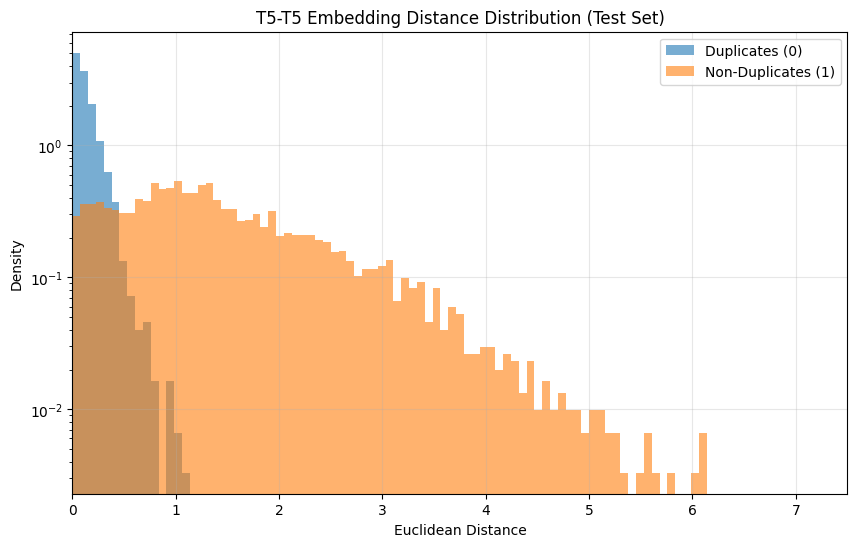

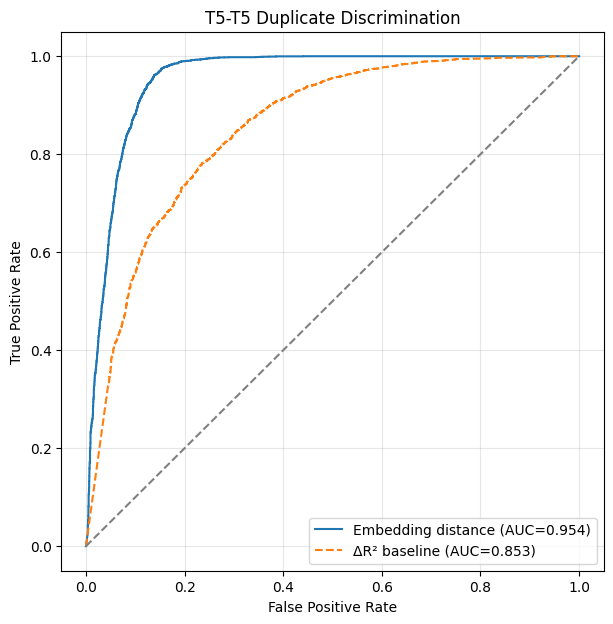

T5-T5 AUC (embedding) = 0.9542
T5-T5 AUC (ΔR²)       = 0.8531


In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embed_t5.eval()

# 1) collect distances and labels
dist_t5_all = []
lbl_t5_all  = []

with torch.no_grad():
    for x_left, x_right, y, _ in test_t5_loader:
        x_left  = x_left.to(device)
        x_right = x_right.to(device)

        e_l = embed_t5(x_left)
        e_r = embed_t5(x_right)
        d   = torch.sqrt(((e_l - e_r) ** 2).sum(dim=1, keepdim=True) + 1e-6)

        dist_t5_all.append(d.cpu().numpy().flatten())
        lbl_t5_all .append(y.numpy().flatten())

dist_t5_all = np.concatenate(dist_t5_all)
lbl_t5_all  = np.concatenate(lbl_t5_all)

print(f"T5-T5 pairs:   {len(dist_t5_all)} distances")
print(f"  Range: min={dist_t5_all.min():.4f}, max={dist_t5_all.max():.4f}")
print(f"  Labels: similar={(lbl_t5_all==0).sum()}, dissimilar={(lbl_t5_all==1).sum()}")

# 2) histogram of distances
plt.figure(figsize=(10,6))
bins = np.linspace(0, 7.5, 100)
plt.hist(dist_t5_all[lbl_t5_all==0], bins=bins, density=True, alpha=0.6, label='Duplicates (0)')
plt.hist(dist_t5_all[lbl_t5_all==1], bins=bins, density=True, alpha=0.6, label='Non-Duplicates (1)')
plt.yscale('log')
plt.xlabel("Euclidean Distance")
plt.ylabel("Density")
plt.title("T5-T5 Embedding Distance Distribution (Test Set)")
plt.legend()
plt.grid(alpha=0.3)
plt.xlim(0,7.5)
plt.show()

# ------------------------------------------------------------------
# ΔR² baseline for the same test split
# ------------------------------------------------------------------
phi_left  = np.arctan2(X_left_test[:, 2], X_left_test[:, 1])
phi_right = np.arctan2(X_right_test[:, 2], X_right_test[:, 1])
eta_left  = X_left_test[:, 0]  * eta_max     # undo η‑normalisation
eta_right = X_right_test[:, 0] * eta_max

dphi = (phi_left - phi_right + np.pi) % (2*np.pi) - np.pi
deta = eta_left - eta_right
dRsq = dphi**2 + deta**2

# 3) ROC curves: embedding vs ΔR² baseline
fpr_t5, tpr_t5, _ = roc_curve(lbl_t5_all, -dist_t5_all, pos_label=0)
fpr_dr, tpr_dr, _ = roc_curve(lbl_t5_all, -dRsq,        pos_label=0)

auc_t5 = auc(fpr_t5, tpr_t5)
auc_dr = auc(fpr_dr,  tpr_dr)

plt.figure(figsize=(7,7))
plt.plot(fpr_t5, tpr_t5, label=f"Embedding distance (AUC={auc_t5:.3f})")
plt.plot(fpr_dr, tpr_dr, '--', label=f"ΔR² baseline (AUC={auc_dr:.3f})")
plt.plot([0,1],[0,1], '--', color='grey')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("T5-T5 Duplicate Discrimination")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print(f"T5-T5 AUC (embedding) = {auc_t5:.4f}")
print(f"T5-T5 AUC (ΔR²)       = {auc_dr :.4f}")

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


pLS-T5 pairs:  8000 distances
  Range: min=0.0146, max=5.6966
  Labels: similar=4000, dissimilar=4000


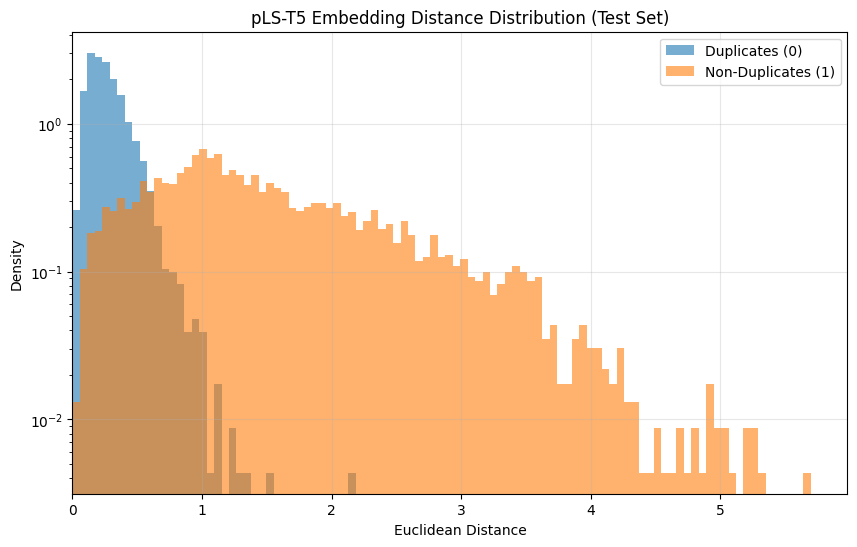

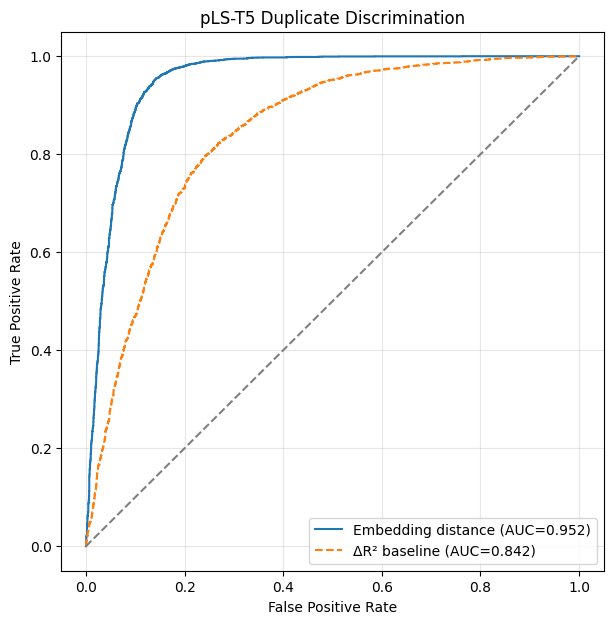

pLS-T5 AUC (embedding) = 0.9518
pLS-T5 AUC (ΔR²)       = 0.8419


In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embed_pls.eval(); embed_t5.eval()

# 1) collect distances and labels ------------------------------------
dist_pls_all = []
lbl_pls_all  = []

with torch.no_grad():
    for pls_feats, t5_feats, y, _ in test_pls_loader:
        pls_feats = pls_feats.to(device)
        t5_feats  = t5_feats.to(device)

        e_p = embed_pls(pls_feats)
        e_t = embed_t5(t5_feats)
        d   = torch.sqrt(((e_p - e_t) ** 2).sum(dim=1, keepdim=True) + 1e-6)

        dist_pls_all.append(d.cpu().numpy().flatten())
        lbl_pls_all .append(y.numpy().flatten())

dist_pls_all = np.concatenate(dist_pls_all)
lbl_pls_all  = np.concatenate(lbl_pls_all)

print(f"pLS-T5 pairs:  {len(dist_pls_all)} distances")
print(f"  Range: min={dist_pls_all.min():.4f}, max={dist_pls_all.max():.4f}")
print(f"  Labels: similar={(lbl_pls_all==0).sum()}, dissimilar={(lbl_pls_all==1).sum()}")

# 2) histogram of distances ------------------------------------------
plt.figure(figsize=(10,6))
bins = np.linspace(0, dist_pls_all.max(), 100)
plt.hist(dist_pls_all[lbl_pls_all==0], bins=bins, density=True, alpha=0.6, label='Duplicates (0)')
plt.hist(dist_pls_all[lbl_pls_all==1], bins=bins, density=True, alpha=0.6, label='Non-Duplicates (1)')
plt.yscale('log')
plt.xlabel("Euclidean Distance")
plt.ylabel("Density")
plt.title("pLS-T5 Embedding Distance Distribution (Test Set)")
plt.legend()
plt.grid(alpha=0.3)
plt.xlim(left=0)
plt.show()

# --------------------------------------------------------------------
# ΔR² baseline for the same pLS-T5 pairs
# --------------------------------------------------------------------
#  — recover φ and η for the raw feature arrays used in the split
phi_left  = np.arctan2(X_pls_test[:, 3],  X_pls_test[:, 2])     # pLS: sinφ, cosφ
phi_right = np.arctan2(X_t5raw_test[:, 2], X_t5raw_test[:, 1])  # T5 : sinφ, cosφ
eta_left  = X_pls_test[:, 0]  * 4.0        # pLS stored η/4
eta_right = X_t5raw_test[:, 0] * eta_max   # T5  stored η/η_max

dphi = (phi_left - phi_right + np.pi) % (2*np.pi) - np.pi
deta = eta_left - eta_right
dRsq = dphi**2 + deta**2

# 3) ROC curves: embedding vs ΔR² baseline ---------------------------
fpr_pls, tpr_pls, _ = roc_curve(lbl_pls_all, -dist_pls_all, pos_label=0)
fpr_dr,  tpr_dr,  _ = roc_curve(lbl_pls_all, -dRsq,         pos_label=0)

auc_pls = auc(fpr_pls, tpr_pls)
auc_dr  = auc(fpr_dr,  tpr_dr)

plt.figure(figsize=(7,7))
plt.plot(fpr_pls, tpr_pls, label=f"Embedding distance (AUC={auc_pls:.3f})")
plt.plot(fpr_dr,  tpr_dr,  '--', label=f"ΔR² baseline (AUC={auc_dr:.3f})")
plt.plot([0,1],[0,1], '--', color='grey')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("pLS-T5 Duplicate Discrimination")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print(f"pLS-T5 AUC (embedding) = {auc_pls:.4f}")
print(f"pLS-T5 AUC (ΔR²)       = {auc_dr :.4f}")

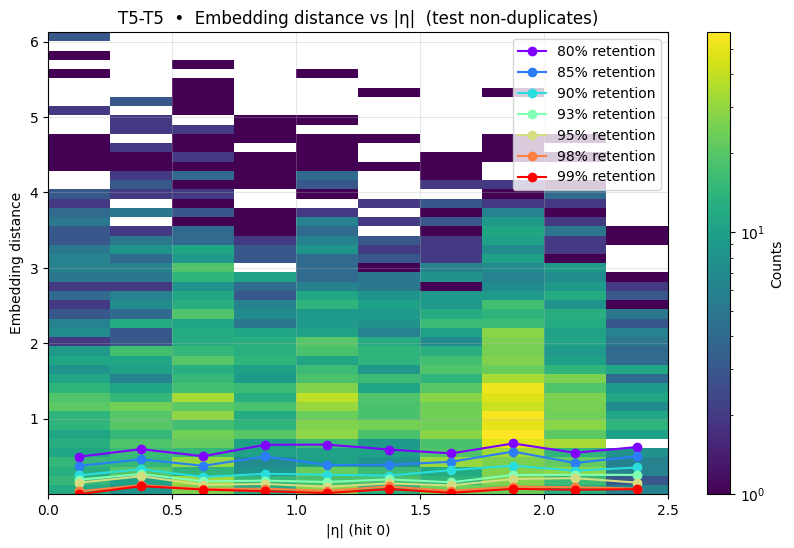

80%-cut:     { 0.4987, 0.5986, 0.5040, 0.6563, 0.6582, 0.5931, 0.5421, 0.6735, 0.5500, 0.6269 }
  80%-dupRej: { 95.54, 97.31, 97.76, 100.00, 99.52, 98.85, 99.34, 99.08, 99.65, 100.00 }

85%-cut:     { 0.3775, 0.4625, 0.3775, 0.5017, 0.3882, 0.3914, 0.4309, 0.5661, 0.4153, 0.5031 }
  85%-dupRej: { 88.84, 93.85, 93.28, 98.02, 95.48, 93.13, 97.82, 98.73, 98.94, 100.00 }

90%-cut:     { 0.2516, 0.3332, 0.2297, 0.2718, 0.2597, 0.2479, 0.3207, 0.3789, 0.3127, 0.3557 }
  90%-dupRej: { 74.11, 85.38, 75.86, 88.12, 85.71, 79.77, 93.01, 94.82, 95.59, 98.11 }

93%-cut:     { 0.1932, 0.2692, 0.1713, 0.1809, 0.1637, 0.1976, 0.1595, 0.2564, 0.2593, 0.2568 }
  93%-dupRej: { 66.52, 78.46, 61.38, 77.72, 63.10, 72.14, 65.72, 88.36, 93.47, 93.71 }

95%-cut:     { 0.1533, 0.2391, 0.1257, 0.1367, 0.0995, 0.1440, 0.1174, 0.2030, 0.2138, 0.1547 }
  95%-dupRej: { 56.70, 74.23, 44.83, 61.39, 40.24, 58.78, 53.93, 80.30, 91.01, 84.28 }

98%-cut:     { 0.0404, 0.1203, 0.0715, 0.0745, 0.0465, 0.1042, 0.0452, 0.1023

In [33]:
import numpy as np, torch, matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

percentiles   = [80, 85, 90, 93, 95, 98, 99]   # keep this % of non‑duplicates
eta_edges     = np.arange(0.0, 2.75, 0.25)     # |η| binning
dr2_threshold = 1.0e-3                         # ΔR² cut

eta_L  = X_left_test[:, 0] * eta_max
phi_L  = np.arctan2(X_left_test[:, 2], X_left_test[:, 1])
eta_R  = X_right_test[:, 0] * eta_max
phi_R  = np.arctan2(X_right_test[:, 2], X_right_test[:, 1])

abs_eta = np.abs(eta_L)

deta = eta_L - eta_R
dphi = (phi_R - phi_L + np.pi) % (2*np.pi) - np.pi
dR2  = deta**2 + dphi**2                       # ΔR² baseline

embed_t5.eval()
with torch.no_grad():
    L = torch.from_numpy(X_left_test.astype(np.float32)).to(device)
    R = torch.from_numpy(X_right_test.astype(np.float32)).to(device)
    dist = torch.sqrt(((embed_t5(L) - embed_t5(R))**2).sum(dim=1) + 1e-6) \
             .cpu().numpy()

y_test = y_t5_test                              # shorthand

cut_vals   = {p: [] for p in percentiles}
dup_rej    = {p: [] for p in percentiles}
dr2_eff    = []
dr2_rejdup = []

for lo, hi in zip(eta_edges[:-1], eta_edges[1:]):
    nnd = (abs_eta >= lo) & (abs_eta < hi) & (y_test == 1)   # non‑dups
    dup = (abs_eta >= lo) & (abs_eta < hi) & (y_test == 0)   # dups

    # ΔR² metrics
    dr2_eff   .append(np.mean(dR2[nnd] >= dr2_threshold)*100 if np.any(nnd) else np.nan)
    dr2_rejdup.append(np.mean(dR2[dup] <  dr2_threshold)*100 if np.any(dup) else np.nan)

    # embedding‑distance cuts
    for p in percentiles:
        cut = np.percentile(dist[nnd], 100-p) if np.any(nnd) else np.nan
        cut_vals[p].append(cut)
        dup_rej[p].append(np.mean(dist[dup] < cut)*100 if (np.any(dup) and not np.isnan(cut)) else np.nan)

fig, ax = plt.subplots(figsize=(10,6))
h = ax.hist2d(abs_eta[y_test==1], dist[y_test==1],
              bins=[eta_edges, 50], norm=LogNorm())
fig.colorbar(h[3], ax=ax, label='Counts')
ax.set_xlabel('|η| (hit 0)')
ax.set_ylabel('Embedding distance')
ax.set_title('T5-T5  •  Embedding distance vs |η|  (test non‑duplicates)')

mid_eta = eta_edges[:-1] + 0.5*np.diff(eta_edges)
for p, clr in zip(percentiles, plt.cm.rainbow(np.linspace(0,1,len(percentiles)))):
    ax.plot(mid_eta, cut_vals[p], '-o', color=clr, label=f'{p}% retention')
ax.legend(); ax.grid(alpha=0.3); plt.show()

for p in percentiles:
    cuts = ", ".join(f"{v:.4f}" if not np.isnan(v) else "nan" for v in cut_vals[p])
    rejs = ", ".join(f"{v:.2f}"  if not np.isnan(v) else "nan" for v in dup_rej[p])
    print(f"{p}%-cut:     {{ {cuts} }}")
    print(f"  {p}%-dupRej: {{ {rejs} }}")
    print()
eff = ", ".join(f"{v:.2f}" if not np.isnan(v) else "nan" for v in dr2_eff)
rej = ", ".join(f"{v:.2f}" if not np.isnan(v) else "nan" for v in dr2_rejdup)
print(f"dR2-eff  (%): {{ {eff} }}")
print(f"dR2-dupRej (%): {{ {rej} }}")

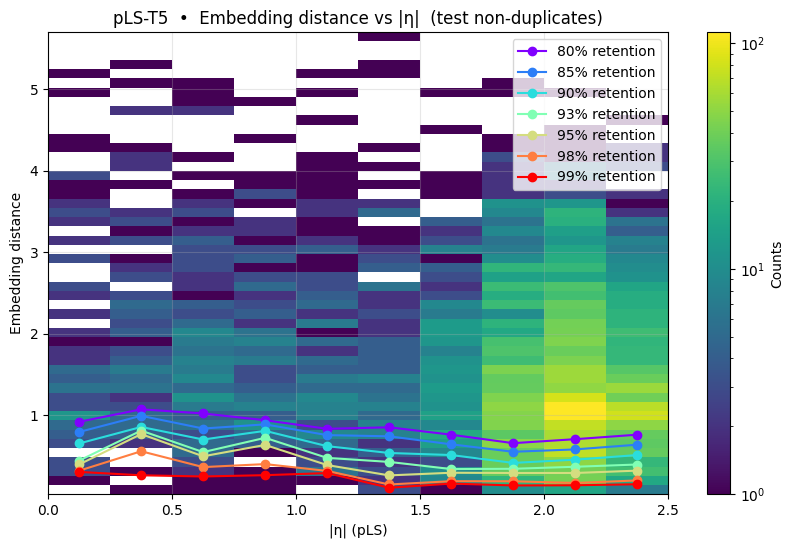

80%-cut:     { 0.9172, 1.0704, 1.0194, 0.9364, 0.8313, 0.8500, 0.7591, 0.6552, 0.7040, 0.7590 }
  80%-dupRej: { 98.53, 98.39, 99.06, 98.46, 98.45, 98.06, 99.35, 96.40, 98.43, 97.67 }

85%-cut:     { 0.7926, 0.9905, 0.8348, 0.8858, 0.7539, 0.7392, 0.6413, 0.5495, 0.5787, 0.6363 }
  85%-dupRej: { 98.53, 96.77, 97.17, 98.46, 97.67, 95.15, 97.10, 93.34, 95.43, 95.61 }

90%-cut:     { 0.6516, 0.8538, 0.7000, 0.8062, 0.6182, 0.5347, 0.5096, 0.4130, 0.4527, 0.5093 }
  90%-dupRej: { 95.59, 96.77, 94.34, 95.38, 96.12, 94.17, 90.32, 85.37, 87.25, 89.41 }

93%-cut:     { 0.4420, 0.8089, 0.5453, 0.7207, 0.4746, 0.4252, 0.3376, 0.3409, 0.3655, 0.3933 }
  93%-dupRej: { 75.00, 96.77, 83.96, 93.85, 83.72, 84.47, 70.97, 73.58, 78.60, 78.04 }

95%-cut:     { 0.3940, 0.7664, 0.4942, 0.6333, 0.3864, 0.2598, 0.2922, 0.2895, 0.2893, 0.3181 }
  95%-dupRej: { 67.65, 96.77, 77.36, 92.31, 66.67, 44.66, 61.61, 65.17, 63.05, 66.02 }

98%-cut:     { 0.3176, 0.5559, 0.3616, 0.3984, 0.3146, 0.1482, 0.1888, 0.1878, 0

In [34]:
import numpy as np, torch, matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

percentiles   = [80, 85, 90, 93, 95, 98, 99]
eta_edges     = np.arange(0.0, 2.75, 0.25)
dr2_threshold = 1.0e-3

eta_L  = X_pls_test[:, 0] * 4.0                     # pLS η was stored as η/4
phi_L  = np.arctan2(X_pls_test[:, 3], X_pls_test[:, 2])
eta_R  = X_t5raw_test[:, 0] * eta_max
phi_R  = np.arctan2(X_t5raw_test[:, 2], X_t5raw_test[:, 1])

abs_eta = np.abs(eta_L)

deta = eta_L - eta_R
dphi = (phi_R - phi_L + np.pi) % (2*np.pi) - np.pi
dR2  = deta**2 + dphi**2

embed_pls.eval(); embed_t5.eval()
with torch.no_grad():
    L = torch.from_numpy(X_pls_test.astype(np.float32)).to(device)
    R = torch.from_numpy(X_t5raw_test.astype(np.float32)).to(device)
    dist = torch.sqrt(((embed_pls(L) - embed_t5(R))**2).sum(dim=1) + 1e-6) \
             .cpu().numpy()

y_test = y_pls_test

cut_vals   = {p: [] for p in percentiles}
dup_rej    = {p: [] for p in percentiles}
dr2_eff    = []
dr2_rejdup = []

for lo, hi in zip(eta_edges[:-1], eta_edges[1:]):
    nnd = (abs_eta >= lo) & (abs_eta < hi) & (y_test == 1)
    dup = (abs_eta >= lo) & (abs_eta < hi) & (y_test == 0)

    dr2_eff   .append(np.mean(dR2[nnd] >= dr2_threshold)*100 if np.any(nnd) else np.nan)
    dr2_rejdup.append(np.mean(dR2[dup] <  dr2_threshold)*100 if np.any(dup) else np.nan)

    for p in percentiles:
        cut = np.percentile(dist[nnd], 100-p) if np.any(nnd) else np.nan
        cut_vals[p].append(cut)
        dup_rej[p].append(np.mean(dist[dup] < cut)*100 if (np.any(dup) and not np.isnan(cut)) else np.nan)

fig, ax = plt.subplots(figsize=(10,6))
h = ax.hist2d(abs_eta[y_test==1], dist[y_test==1],
              bins=[eta_edges, 50], norm=LogNorm())
fig.colorbar(h[3], ax=ax, label='Counts')
ax.set_xlabel('|η| (pLS)')
ax.set_ylabel('Embedding distance')
ax.set_title('pLS-T5  •  Embedding distance vs |η|  (test non-duplicates)')

mid_eta = eta_edges[:-1] + 0.5*np.diff(eta_edges)
for p, clr in zip(percentiles, plt.cm.rainbow(np.linspace(0,1,len(percentiles)))):
    ax.plot(mid_eta, cut_vals[p], '-o', color=clr, label=f'{p}% retention')
ax.legend(); ax.grid(alpha=0.3); plt.show()

for p in percentiles:
    cuts = ", ".join(f"{v:.4f}" if not np.isnan(v) else "nan" for v in cut_vals[p])
    rejs = ", ".join(f"{v:.2f}"  if not np.isnan(v) else "nan" for v in dup_rej[p])
    print(f"{p}%-cut:     {{ {cuts} }}")
    print(f"  {p}%-dupRej: {{ {rejs} }}")
    print()
eff = ", ".join(f"{v:.2f}" if not np.isnan(v) else "nan" for v in dr2_eff)
rej = ", ".join(f"{v:.2f}" if not np.isnan(v) else "nan" for v in dr2_rejdup)
print(f"dR2-eff  (%): {{ {eff} }}")
print(f"dR2-dupRej (%): {{ {rej} }}")

In [35]:
def print_formatted_weights_biases(weights, biases, layer_name):
    # Print biases
    print(f"HOST_DEVICE_CONSTANT float bias_{layer_name}[{len(biases)}] = {{")
    print(", ".join(f"{b:.7f}f" for b in biases) + " };")
    print()

    # Print weights
    print(f"HOST_DEVICE_CONSTANT const float wgtT_{layer_name}[{len(weights[0])}][{len(weights)}] = {{")
    for row in weights.T:
        formatted_row = ", ".join(f"{w:.7f}f" for w in row)
        print(f"{{ {formatted_row} }},")
    print("};")
    print()

def print_model_weights_biases(model):
    # Make sure the model is in evaluation mode
    model.eval()

    # Iterate through all named modules in the model
    for name, module in model.named_modules():
        # Check if the module is a linear layer
        if isinstance(module, nn.Linear):
            # Get weights and biases
            weights = module.weight.data.cpu().numpy()
            biases = module.bias.data.cpu().numpy()

            # Print formatted weights and biases
            print_formatted_weights_biases(weights, biases, name.replace('.', '_'))

In [36]:
print_model_weights_biases(embed_pls)

HOST_DEVICE_CONSTANT float bias_fc1[32] = {
0.0027716f, 0.1833940f, 0.0437481f, -0.0527663f, 0.0642794f, 0.2502241f, -0.0239751f, 0.2045865f, 0.1738954f, -0.2696084f, -0.0195633f, -0.3172239f, -0.1345879f, -0.0906492f, 0.0710623f, -0.0965978f, 0.5400854f, -0.3849348f, -0.2359036f, 0.0064980f, 0.0019173f, -0.0165273f, 0.3708883f, -0.1319823f, -0.1654108f, -0.0048566f, 0.3200995f, 0.0559153f, 0.1860648f, 0.1403919f, 0.3456852f, 0.2525786f };

HOST_DEVICE_CONSTANT const float wgtT_fc1[10][32] = {
{ 0.0104559f, 0.1600890f, 0.0927634f, -0.2303483f, -0.0563969f, 0.0061827f, -0.2472638f, 0.0377883f, -0.0259518f, -0.0598272f, -0.4608885f, 0.2273800f, -0.0014492f, 0.0535469f, 0.2873713f, 0.4725961f, 0.2000864f, -0.2132182f, -0.0864691f, 0.0129386f, 0.0415365f, 0.1382795f, 0.0403005f, 0.1174317f, -0.1489394f, 0.0006531f, -0.7378463f, -0.2903035f, -0.1091498f, 0.0491977f, -0.1972693f, 0.3444668f },
{ 0.0265098f, -0.2574369f, -0.2708310f, 0.0855853f, -0.0496918f, -0.0214932f, -0.2673061f, -0.14143

In [37]:
print_model_weights_biases(embed_t5)

HOST_DEVICE_CONSTANT float bias_fc1[32] = {
-0.0245482f, 0.0508991f, 0.0400742f, 0.1255749f, 0.0367470f, 0.2185066f, 0.2395958f, 0.1033633f, -0.0476017f, 0.0008649f, 0.0442964f, 0.1895439f, 0.1297693f, 0.0828288f, 0.2803719f, 0.1229684f, 0.0380638f, 0.2433829f, 0.2561882f, 0.2362680f, 0.0780241f, 0.0682562f, 0.1239538f, 0.2512406f, -0.2199214f, 0.1086161f, 0.0690891f, 0.1498078f, 0.1742166f, 0.0363806f, 0.0777571f, 0.2601018f };

HOST_DEVICE_CONSTANT const float wgtT_fc1[30][32] = {
{ -0.0424017f, 0.0331677f, -0.0060546f, 0.0227199f, -0.0253375f, -0.0069197f, 0.0023105f, 0.0558283f, -0.1293409f, 0.1334358f, 0.0044231f, 0.0031409f, -0.0066191f, 0.0219152f, -0.0605371f, -0.1096990f, -0.0647859f, -0.0436599f, 0.0548519f, -0.1351903f, 0.0192650f, 0.0171163f, -0.1932238f, -0.0261385f, -0.0096621f, 0.0193477f, 0.0328733f, 0.1216419f, -0.0319816f, -0.0290272f, 0.0545698f, -0.0456655f },
{ 0.0348014f, -0.0308982f, -0.1021456f, 0.0444723f, -0.0307102f, -0.0406721f, 0.1198447f, 0.0797071f, -0.01

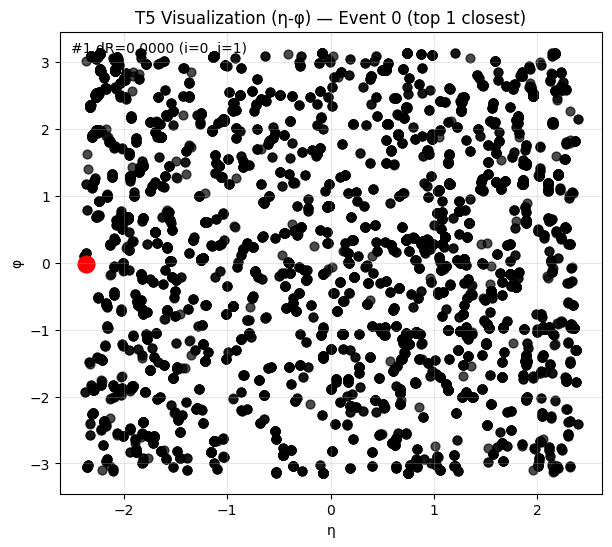

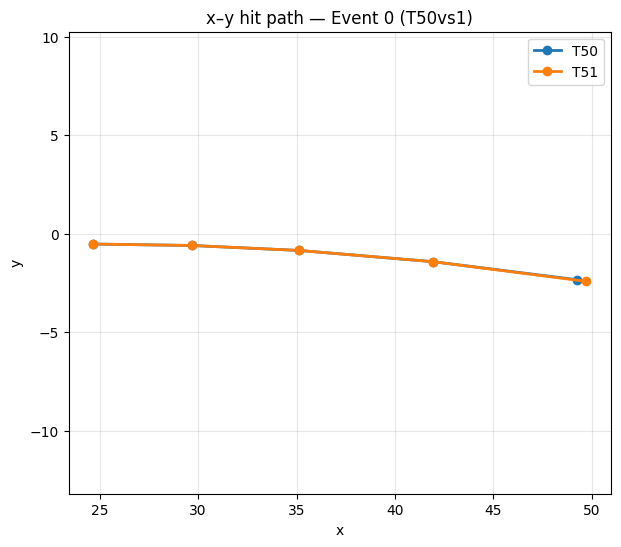

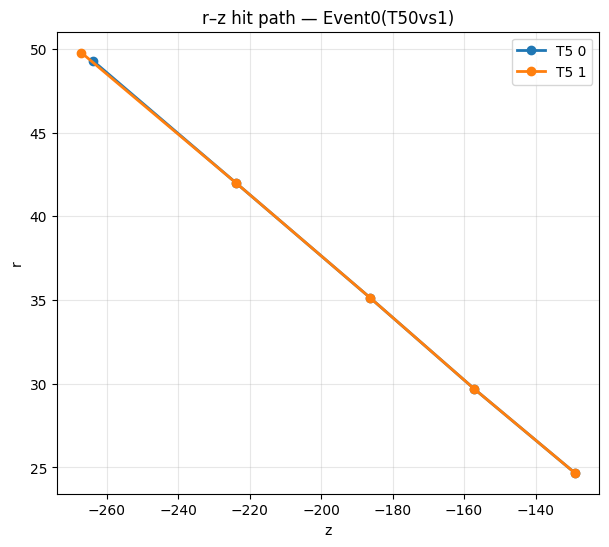

In [38]:
def _wrap_delta_phi(phi1, phi2):
    d = phi1 - phi2
    if d > np.pi:
        d -= 2*np.pi
    elif d < -np.pi:
        d += 2*np.pi
    return d




def find_k_closest_pairs_eta_phi(eta, phi, k=1):
    """
    returns a list of dR,i,j sorted by increasing dR
    """
    eta = np.asarray(eta)
    phi = np.asarray(phi)
    n = len(eta)
    if n < 2:
        return []

    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            deta = eta[i] - eta[j]
            dphi = _wrap_delta_phi(phi[i], phi[j])
            dR = float(np.sqrt(deta*deta + dphi*dphi))
            pairs.append((dR, i, j))

    pairs.sort(key=lambda x: x[0])
    return pairs[:min(k, len(pairs))]




def plot_t5_eta_phi_topk(branches, event_idx, k=1, threshold=0.05):
    """
    η–φ plot and highlights the closest pair
    """
    eta = branches["t5_eta"][event_idx]
    phi = branches["t5_phi"][event_idx]

    plt.figure(figsize=(7, 6))
    plt.scatter(eta,phi, s=40, color="black", alpha=0.7, label="T5")

    closest = find_k_closest_pairs_eta_phi(eta, phi, k=k)
    if len(closest) == 0:
        plt.title(f"T5 Visualization (η-φ) — Event {event_idx} (no pairs)")
        plt.xlabel("η")
        plt.ylabel("φ")
        plt.grid(alpha=0.3)
        plt.show()
        return []

    for rank, (dR, i, j) in enumerate(closest, start=1):
        strong = (dR < threshold)
        plt.plot([eta[i], eta[j]], [phi[i], phi[j]],
                 'r-', alpha=0.9 if strong else 0.5, linewidth=2 if strong else 1)

        plt.scatter([eta[i], eta[j]], [phi[i], phi[j]],
                    s=140 if strong else 90, color="red", alpha=0.9)

        plt.text(0.02, 0.98 - 0.05*(rank-1),
                 f"#{rank} dR={dR:.4f} (i={i}, j={j})",
                 transform=plt.gca().transAxes, va="top", ha="left")

    plt.xlabel("η")
    plt.ylabel("φ")
    plt.title(f"T5 Visualization (η-φ) — Event {event_idx} (top {len(closest)} closest)")
    plt.grid(alpha=0.3)
    plt.show()

    return closest




def get_t5_hit_points(branches, event_idx, t5_idx):
    """
    extract the 5 hit points for a given T5:
      (0,2,4) from idx0 triplet and (2,4) from idx1 triplet
    and thwn returns dict with arrays: r,z,phi,x,y
    """
    idx0 = branches['t5_t3_idx0'][event_idx][t5_idx]
    idx1 = branches['t5_t3_idx1'][event_idx][t5_idx]

    r = np.array([
        branches['t5_t3_0_r'][event_idx][idx0],
        branches['t5_t3_2_r'][event_idx][idx0],
        branches['t5_t3_4_r'][event_idx][idx0],
        branches['t5_t3_2_r'][event_idx][idx1],
        branches['t5_t3_4_r'][event_idx][idx1],
    ], dtype=float)


    z = np.array([
        branches['t5_t3_0_z'][event_idx][idx0],
        branches['t5_t3_2_z'][event_idx][idx0],
        branches['t5_t3_4_z'][event_idx][idx0],
        branches['t5_t3_2_z'][event_idx][idx1],
        branches['t5_t3_4_z'][event_idx][idx1],
    ], dtype=float)


    phi = np.array([
        branches['t5_t3_0_phi'][event_idx][idx0],
        branches['t5_t3_2_phi'][event_idx][idx0],
        branches['t5_t3_4_phi'][event_idx][idx0],
        branches['t5_t3_2_phi'][event_idx][idx1],
        branches['t5_t3_4_phi'][event_idx][idx1],
    ], dtype=float)


    x = r * np.cos(phi)
    y = r * np.sin(phi)

    return {"r": r, "z": z, "phi": phi, "x": x, "y": y}

def plot_two_t5_paths(branches,event_idx,t5_i,t5_j):
    """
    Plots the two hit paths in x–y and r–z.
    """
    A = get_t5_hit_points(branches,event_idx, t5_i)
    B = get_t5_hit_points(branches,event_idx, t5_j)






    # x y view
    plt.figure(figsize=(7, 6))
    plt.plot(A["x"], A["y"], "-o",linewidth=2,markersize=6,label=f"T5{t5_i}")
    plt.plot(B["x"],B["y"],"-o",linewidth=2,markersize=6,label=f"T5{t5_j}")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(f"x–y hit path — Event {event_idx} (T5{t5_i}vs{t5_j})")
    plt.axis("equal")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.show()



    # r z view
    plt.figure(figsize=(7,6))
    plt.plot(A["z"], A["r"], "-o",linewidth=2,markersize=6,label=f"T5 {t5_i}")
    plt.plot(B["z"], B["r"], "-o",linewidth=2,markersize=6,label=f"T5 {t5_j}")
    plt.xlabel("z")
    plt.ylabel("r")
    plt.title(f"r–z hit path — Event{event_idx}(T5{t5_i}vs{t5_j})")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.show()

event_idx = 0
topk = plot_t5_eta_phi_topk(branches, event_idx=event_idx, k=1, threshold=0.05)

if len(topk) > 0:
    _, i, j = topk[0]
    plot_two_t5_paths(branches, event_idx, i, j)
